# Kalman filters Denmark
Once the data is presented, each model is defined as a function using numpyro, run and plotted (both sample distributions and forecasting results).

### Table of contents
1. [Data](#Data)
2. [Model with the vector c fixed as [0, 1]](#Model-with-the-vector-c-fixed-as-[0,-1])
3. [Model with the vector c as a random variable with prior](#Model-with-the-vector-c-as-a-random-variable-with-prior)
4. [Model without input (2 hidden variables)](#Model-without-input)
5. [Gaussian Process](#Gaussian-Process)

In [0]:
# The below is helpful to upload local file to the colab 
#from google.colab import files
from os.path import join, pardir

# Pandas is needed in most of the cases:
import pandas as pd

# The code below will make the GUI to upload the local file
uploaded = files.upload()

Saving data_denmark_sixcol.csv to data_denmark_sixcol (1).csv


In [0]:
# these imports are separated in case you just
# want to run the initial analysis
import time
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import seaborn as sns
import matplotlib.pyplot as plt


import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax
np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [0]:
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [0]:
from sklearn.preprocessing import StandardScaler

In [3]:
ROOT = pardir
DATA = join(ROOT, "data", "processed")

# Data
Mobility data from Google (57 data points; i.e., 57 dates) + confirmed cases for that period.

In [0]:
data = pd.read_csv(join(DATA, 'data_denmark_sixcol.csv')).values
X = data[:, 2:].astype(np.float_)
y = data[:,1].astype(np.float_)

n_train = 45
n_test = len(y)-n_train

idx_train = [*range(0,n_train)]
idx_test = [*range(n_train, len(y))]

y_train = y[idx_train]
y_test = y[idx_test]
"""
X_train = X[idx_train,:]
X_test = X[idx_test,:]
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = np.vstack((X_train, X_test))
"""

'\nX_train = X[idx_train,:]\nX_test = X[idx_test,:]\nscaler = StandardScaler()\nscaler.fit(X_train)\nX_train = scaler.transform(X_train)\nX_test = scaler.transform(X_test)\nX = np.vstack((X_train, X_test))\n'

## Model with the vector c fixed as [0, 1]

First model: the sampling distribution is replaced by one fixed variable $c$.

In [0]:
def f(carry, input_t):
  x_t, noise_t = input_t
  W, beta, z_prev, tau = carry
  z_t = beta*z_prev + W @ x_t + noise_t
  z_prev = z_t
  return (W, beta, z_prev, tau), z_t

In [0]:
def model_wo_c(T, T_forecast, x, obs=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    W = numpyro.sample(name="W", fn=dist.Normal(loc=jnp.zeros((2,4)), scale=jnp.ones((2,4))))
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(2)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower), sample_shape=(T+T_forecast,))
    # Propagate the dynamics forward using jax.lax.scan
    carry = (W, beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, (x, noises), T+T_forecast)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
  
    obs_mean = z_collection[:T, 1]
    pred_mean = z_collection[T:,1]

    # Sample the observed y (y_obs) 
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=obs_mean, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=pred_mean, scale=sigma), obs=None)

In [0]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model_wo_c)
mcmc = MCMC(nuts_kernel, num_samples=9000, num_warmup=3000, num_chains=1)
mcmc.run(rng_key_, T=n_train, T_forecast=n_test, x=X, obs=y_train)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 12000/12000 [04:10<00:00, 47.84it/s, 1023 steps of size 1.03e-03. acc. prob=0.62]


Total time: 4.400m


Plots of the distribution of the samples for each variable.

In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

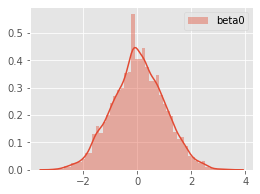

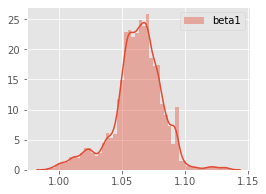

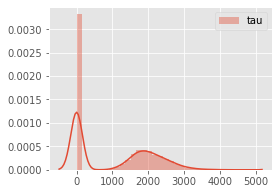

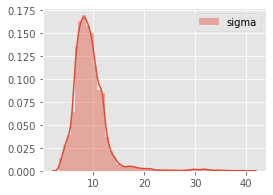

In [0]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  if node == "beta":
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

In [0]:
y_hat = hmc_samples["y_pred"].mean(axis=0)
y_std = hmc_samples["y_pred"].std(axis=0)

In [0]:
y_pred_025 = y_hat - 1.96*y_std
y_pred_975 = y_hat + 1.96*y_std

Forecasting prediction, all the datapoints in the test set are within the Confidence Interval.

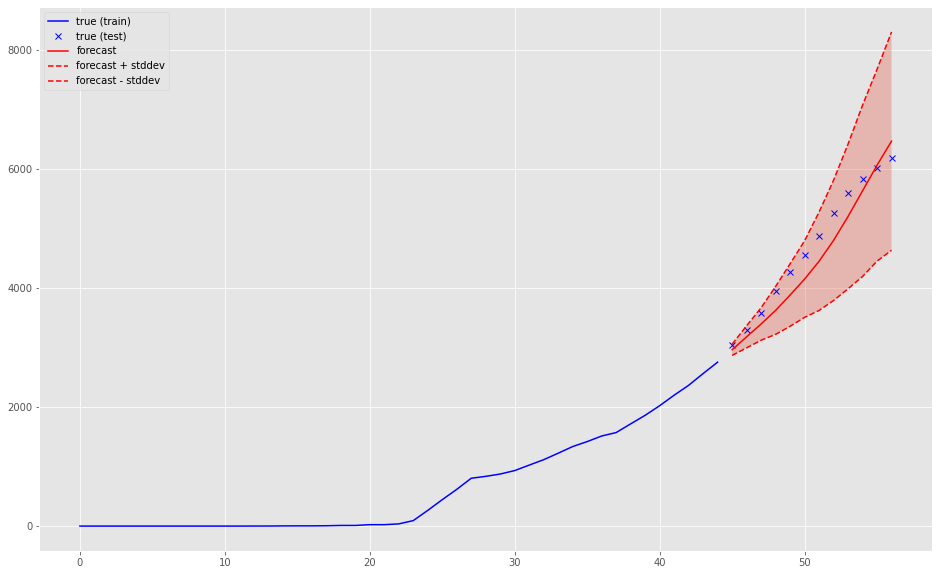

In [0]:
plt.plot(idx_train, y_train, "b-")
plt.plot(idx_test, y_test, "bx")
plt.plot(idx_test, y_hat[:-1], "r-")
plt.plot(idx_test, y_pred_025[:-1], "r--")
plt.plot(idx_test, y_pred_975[:-1], "r--")
plt.fill_between(idx_test, y_pred_025[:-1], y_pred_975[:-1], alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

## Model with the vector c as a random variable with prior

Second model: the sampling distribution is a Normal distribution $c$.

In [0]:
def model_w_c(T, T_forecast, x, obs=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    W = numpyro.sample(name="W", fn=dist.Normal(loc=jnp.zeros((2,4)), scale=jnp.ones((2,4))))
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.array([0.,0.]), scale=jnp.ones(2)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(2)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower), sample_shape=(T+T_forecast,))
    # Propagate the dynamics forward using jax.lax.scan
    carry = (W, beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, (x, noises), T+T_forecast)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    c = numpyro.sample(name="c", fn=dist.Normal(loc=jnp.array([[0.], [0.]]), scale=jnp.ones((2,1))))
    obs_mean = jnp.dot(z_collection[:T,:], c).squeeze()
    pred_mean = jnp.dot(z_collection[T:,:], c).squeeze()

    # Sample the observed y (y_obs) 
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=obs_mean, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=pred_mean, scale=sigma), obs=None)

In [0]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model_w_c)
mcmc = MCMC(nuts_kernel, num_samples=9000, num_warmup=3000, num_chains=1)
mcmc.run(rng_key_, T=n_train, T_forecast=n_test, x=X, obs=y_train)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 12000/12000 [04:50<00:00, 41.29it/s, 1023 steps of size 4.06e-04. acc. prob=0.88]


Total time: 4.949m


In this case, both beta and sigma show bimodal behavior.

In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

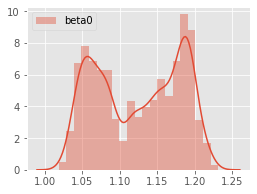

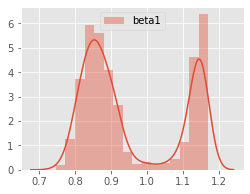

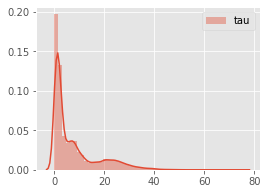

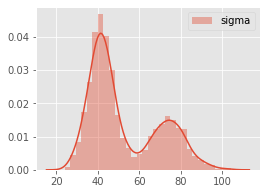

In [0]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  if node == "beta":
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

In [0]:
y_hat = hmc_samples["y_pred"].mean(axis=0)
y_std = hmc_samples["y_pred"].std(axis=0)

In [0]:
y_pred_025 = y_hat - 1.96*y_std
y_pred_975 = y_hat + 1.96*y_std

Forecasting prediction, all the datapoints in the test set are within the Confidence Interval. Although the central tendency shows a better fit for the forecasted values, the standard deviation is higher than that of the previous model.

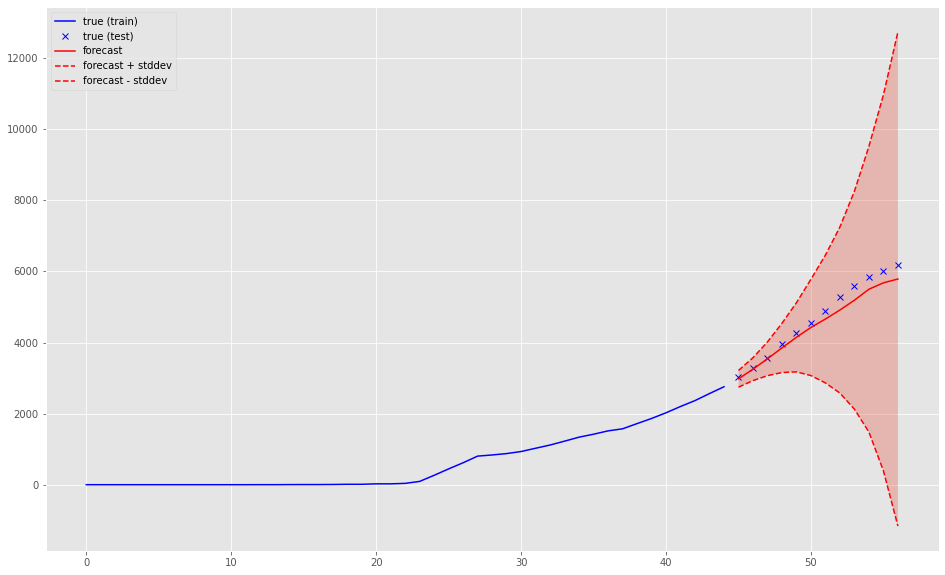

In [0]:
plt.plot(idx_train, y_train, "b-")
plt.plot(idx_test, y_test, "bx")
plt.plot(idx_test, y_hat[:-1], "r-")
plt.plot(idx_test, y_pred_025[:-1], "r--")
plt.plot(idx_test, y_pred_975[:-1], "r--")
plt.fill_between(idx_test, y_pred_025[:-1], y_pred_975[:-1], alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

In [0]:
hmc_samples['W'].mean(axis=0)

DeviceArray([[-0.92419225,  0.5803248 ,  0.14735928, -0.38233298],
             [-0.16688704,  1.5949113 , -0.4462448 , -0.9304285 ]],            dtype=float32)

In [0]:
hmc_samples['c'].mean(axis=0)

DeviceArray([[-1.4487053],
             [ 1.9745528]], dtype=float32)

## Model without input

Third model: no input mobility data, two hidden states.

In [0]:
def f(carry, input_t):
  noise_t = input_t
  beta, z_prev, tau = carry
  z_t = beta*z_prev + noise_t
  z_prev = z_t
  return (beta, z_prev, tau), z_t

In [0]:
def model_w_c(T, T_forecast, obs=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    #W = numpyro.sample(name="W", fn=dist.Normal(loc=jnp.zeros((2,4)), scale=jnp.ones((2,4))))
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.array([0.,0.]), scale=jnp.ones(2)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(2)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower), sample_shape=(T+T_forecast,))
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    c = numpyro.sample(name="c", fn=dist.Normal(loc=jnp.array([[0.], [0.]]), scale=jnp.ones((2,1))))
    obs_mean = jnp.dot(z_collection[:T,:], c).squeeze()
    pred_mean = jnp.dot(z_collection[T:,:], c).squeeze()

    # Sample the observed y (y_obs) 
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=obs_mean, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=pred_mean, scale=sigma), obs=None)

In [0]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model_w_c)
mcmc = MCMC(nuts_kernel, num_samples=9000, num_warmup=3000, num_chains=1)
mcmc.run(rng_key_, T=n_train, T_forecast=n_test, obs=y_train)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 12000/12000 [01:48<00:00, 111.05it/s, 941 steps of size 3.86e-03. acc. prob=0.21]


Total time: 1.909m


As with the previous model, the bimodal behavior is appreciated here; this time with one mode being sampled much less than the other.

In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

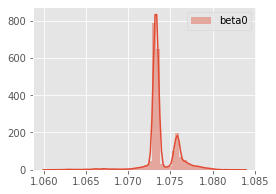

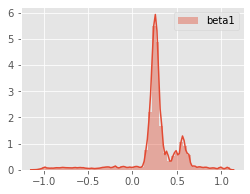

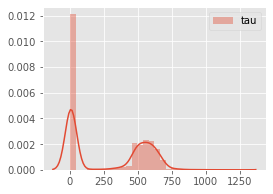

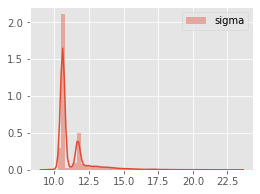

In [0]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  if node == "beta":
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

In [0]:
y_hat = hmc_samples["y_pred"].mean(axis=0)
y_std = hmc_samples["y_pred"].std(axis=0)

In [0]:
y_pred_025 = y_hat - 1.96*y_std
y_pred_975 = y_hat + 1.96*y_std

The forecasting prediction was less satisfactory than the other cases, which indicates that the mobility data enhances the prediciton power of the models.

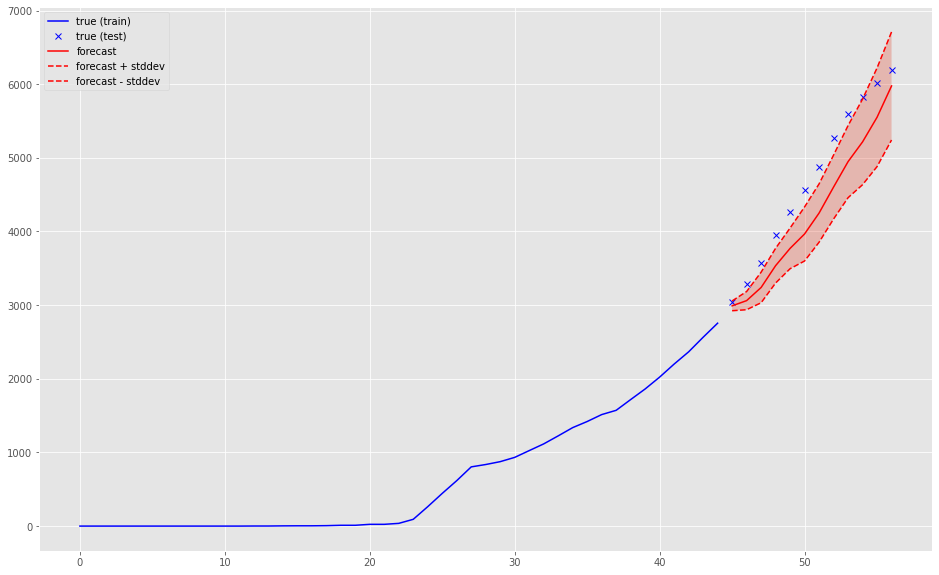

In [0]:
plt.plot(idx_train, y_train, "b-")
plt.plot(idx_test, y_test, "bx")
plt.plot(idx_test, y_hat[:-1], "r-")
plt.plot(idx_test, y_pred_025[:-1], "r--")
plt.plot(idx_test, y_pred_975[:-1], "r--")
plt.fill_between(idx_test, y_pred_025[:-1], y_pred_975[:-1], alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

### Gaussian Process